## Introduction

Welcome to our Machine Learning (ML) project! 🖥️🐾 This project is all about learning the basics of ML by working on a cool task: teaching a computer to tell if there's a mountain lion in a photo or not. While it might sound simple, you'll see that working with real data is quite tricky.

Mountain lions are amazing animals, but sometimes they come too close to places where people live. This can be risky for both people and the lions. Our goal is to use technology to help keep everyone safe. By training a computer model to recognize mountain lions in pictures, we could help warn people when a lion is nearby without harming the animal. 🦁🚫

In this project, you'll learn how to prepare data, train a model, and test how well it works. It's not about making the most advanced technology ever but about understanding how ML can be used to solve real problems.

We're going to work with some basic concepts and tools that scientists use every day. It's a chance to learn a little about a technology that's changing the world.

## Loading the required libraries

In [1]:
import os
import numpy as np

import keras # the main ML library from Google
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

from livelossplot import PlotLossesKeras

10010101234

## Generating our datasets

In [17]:
image_size = (128, 128)  #  <----  First design choice. Hari thinks 256 might be better.
batch_size = 32 # <---- how many images to look at the time to modify the model's internal parameters

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "lion_no_lion",
    shuffle=True,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=image_size,
    color_mode = "grayscale",
    batch_size=batch_size,
)

Found 839 files belonging to 2 classes.
Using 672 files for training.
Using 167 files for validation.


## Computing some stats

In [18]:
def get_label_distribution(dataset):
    label_counts = {}
    
    # Iterate over the dataset to count each label
    for images, labels in dataset:
        unique, counts = np.unique(labels, return_counts=True)
        for label, count in zip(unique, counts):
            if label in label_counts:
                label_counts[label] += count
            else:
                label_counts[label] = count
                
    # Convert label indices to class names (if class names are known)
    class_names = dataset.class_names  # This retrieves the class names
    label_distribution = {class_names[label]: count for label, count in label_counts.items()}
    
    return label_distribution

# Calculate label distributions for both datasets
train_label_counts = get_label_distribution(train_ds)
val_label_counts = get_label_distribution(val_ds)

Corrupt JPEG data: premature end of data segment


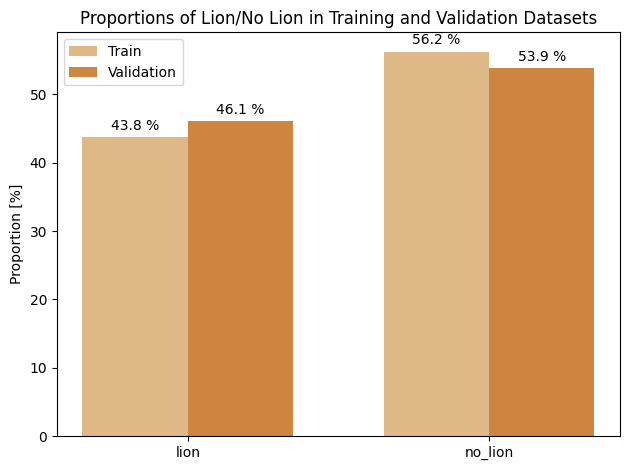

In [19]:
# Names of groups
group_names = list(train_label_counts.keys())

# Values for each group
train_values = list(train_label_counts.values())
val_values = list(val_label_counts.values())

# Calculating proportions
total_train = sum(train_values)
total_val = sum(val_values)
train_proportions = [value*100 / total_train for value in train_values]
val_proportions = [value*100 / total_val for value in val_values]

# Setting up the bar chart
x = np.arange(len(group_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_proportions, width, label='Train', color='burlywood')
rects2 = ax.bar(x + width/2, val_proportions, width, label='Validation', color='peru')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Proportion [%]')
ax.set_title('Proportions of Lion/No Lion in Training and Validation Datasets')
ax.set_xticks(x)
ax.set_xticklabels(group_names)
ax.legend()

# Function to autolabel the bars with their percentages
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f} %',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

## Visualize the data

Here are the first 9 images in the training dataset.

Corrupt JPEG data: premature end of data segment


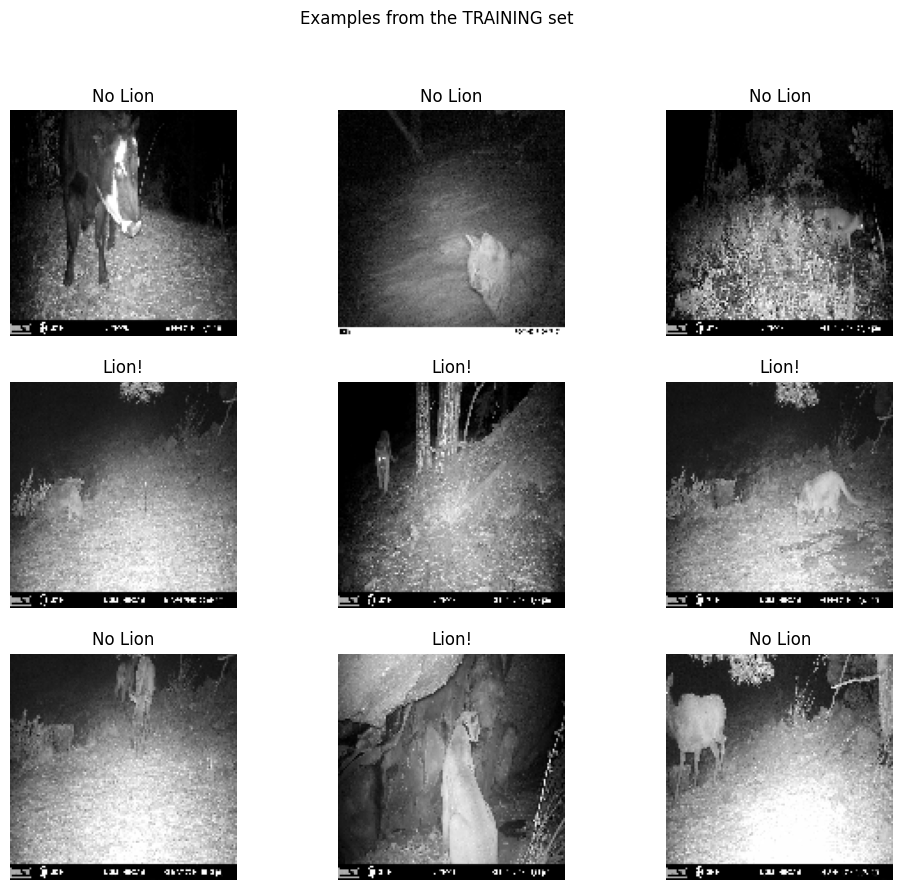

In [20]:
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"), cmap='gray')
        plt.title('No Lion' if int(labels[i])==1 else 'Lion!')
        plt.axis("off")
plt.suptitle('Examples from the TRAINING set');

In [21]:
pic = np.array(images[i]).astype("uint8")
print(f'The shape of each image is {pic.shape}')

The shape of each image is (128, 128, 1)


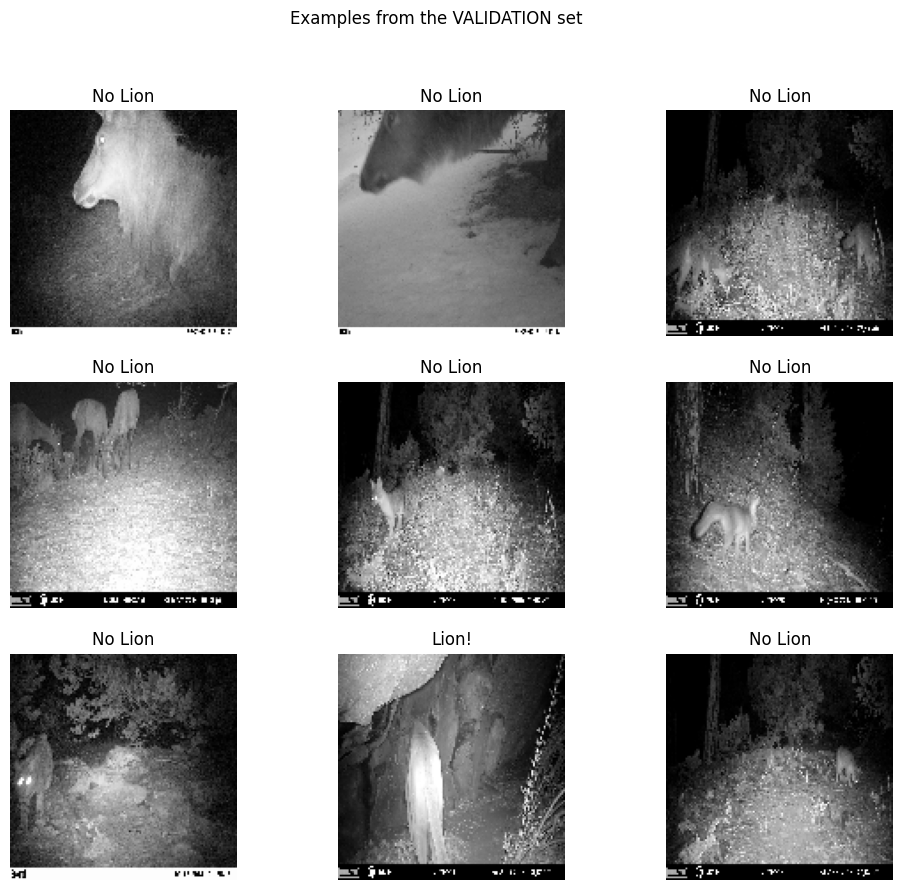

In [22]:
plt.figure(figsize=(12, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"), cmap='gray')
        plt.title('No Lion' if int(labels[i])==1 else 'Lion!')
        plt.axis("off")
plt.suptitle('Examples from the VALIDATION set');

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [25]:
#  <----  These could be things that we can play with
# https://keras.io/api/layers/preprocessing_layers/image_augmentation/

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    #layers.RandomFlip("vertical"),
    layers.RandomRotation(0.01),
    #layers.RandomBrightness,
    #layers.RandomContrast,
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first few images in the dataset:

Corrupt JPEG data: premature end of data segment


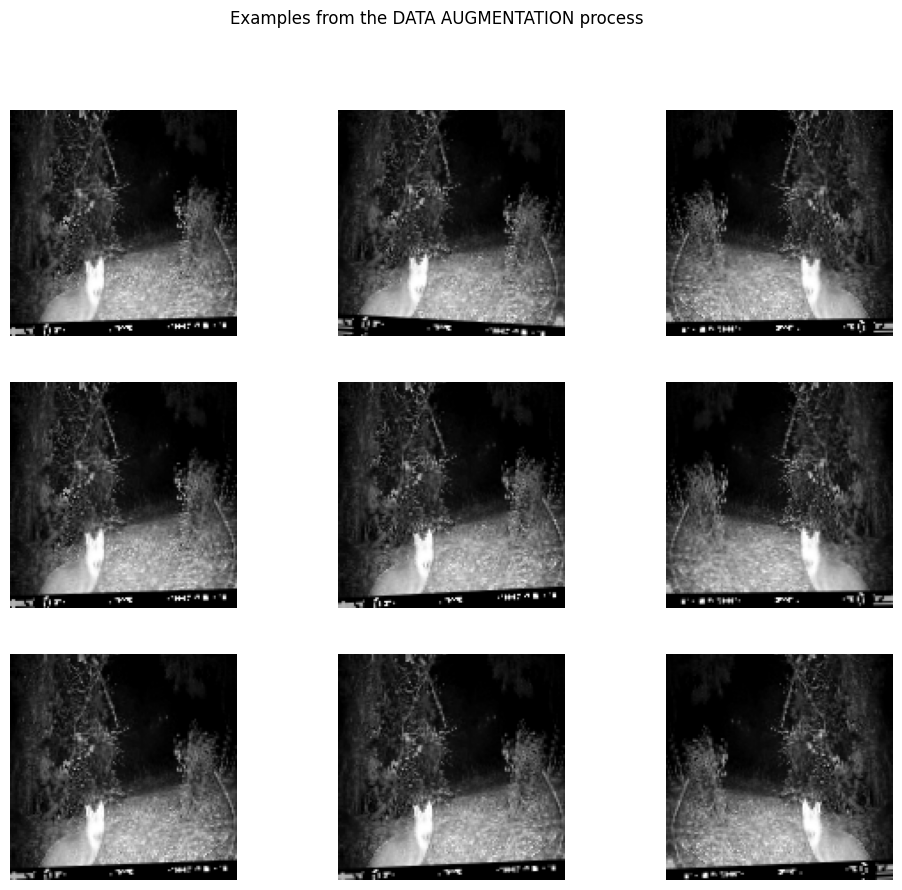

In [26]:
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"), cmap='gray')
        plt.axis("off")
plt.suptitle('Examples from the DATA AUGMENTATION process');

## Internals

In [27]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Build a model

This is a small version of the Xception network. It is not the best AI model for this task. One could cosider using [KerasTuner](https://github.com/keras-team/keras-tuner) to try to find the best possible model.

In [28]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 1, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 1, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 1, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(1, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.1)(x)
    
    outputs = layers.Dense(units, activation=None)(x)
    
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (1,), num_classes=2)

## Some Bells and Whistles

In [29]:
# things that we want to run every epoch

callbacks = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='models/most_accurate_model.keras', 
        monitor='val_acc', 
        save_best_only=True, 
        verbose=1,
        mode='max'  # maximize acc
    ),

 keras.callbacks.CSVLogger(
        filename='logs/training_log.csv', 
        separator=',', 
        append=False
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1,  # New lr = lr * factor.
        patience=500, 
        verbose=1,
        mode='min',
        min_lr=1e-6  # Lower bound on the learning rate.
    ),
    
    PlotLossesKeras()
]


# model internals
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),   # we could also increase this number so it "learns" faster
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

## Training the model

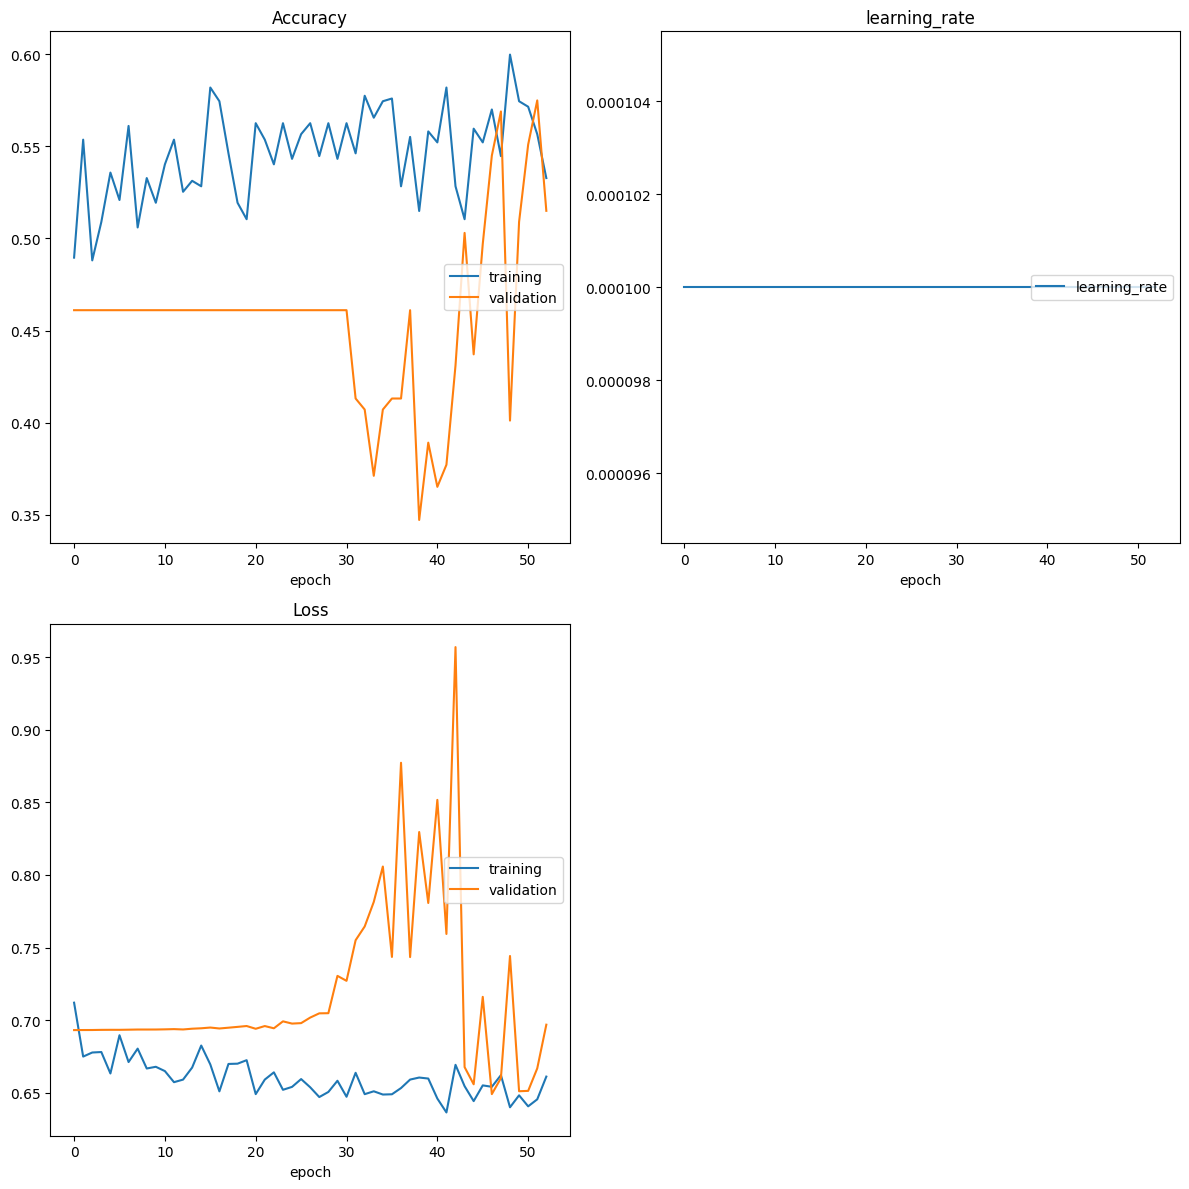

Accuracy
	training         	 (min:    0.488, max:    0.600, cur:    0.533)
	validation       	 (min:    0.347, max:    0.575, cur:    0.515)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.636, max:    0.712, cur:    0.661)
	validation       	 (min:    0.649, max:    0.957, cur:    0.697)
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 998ms/step - acc: 0.5530 - loss: 0.6634 - val_acc: 0.5150 - val_loss: 0.6969 - learning_rate: 1.0000e-04
Epoch 54/5000


Corrupt JPEG data: premature end of data segment


In [ ]:
model.fit(
    train_ds,
    epochs=5_000,
    callbacks=callbacks,
    validation_data=val_ds,
)

In [ ]:
model.load_weights('models/most_accurate_model.keras')

In [ ]:
#plt.figure(figsize=(10, 10))
#for images, labels in val_ds.take(1):
#    for i in range(9):
#        ax = plt.subplot(3, 3, i + 1)
#        logit = model(images[i][None,] ) 
#        print( f'{logit=}' )
#        print( 1 / (1 + np.exp(-logit)) )
#        plt.imshow(np.array(images[i]).astype("uint8"), cmap='gray')
#        plt.title(int(labels[i]))
#        plt.axis("off")

In [ ]:
model.evaluate(val_ds)

## Run inference on an individual image

Note that data augmentation and dropout are inactive at inference time.

In [ ]:
img = keras.utils.load_img("lion_no_lion/lion/MFDC2757.JPG", color_mode='grayscale', target_size=image_size)
plt.imshow(img, cmap='gray')
plt.axis("off")

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% not a lion and {100 * score:.2f}% a lion.")

## Things that we can do to increase performance

- Train with larger images
- Play with all the tuneable parameters above
- Gather more data
- Use data augmentation
- Train for longer
- Model
  - Size: smaller-bigger
  - Different model (or even [Pre-trained models](https://keras.io/api/applications/))
